<a href="https://colab.research.google.com/github/wildbacat/NLP/blob/main/chinese_name.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

Chinese names dataset loading and Vocabulary Building

In [ ]:
# Read Chinese names from the dataset
words = open('sampled_names.txt', 'r', encoding='utf-8').read().splitlines()
# Print the first 8 names to verify successful loading of the dataset
print(f"First 8 names: {words[:8]}")
# Print the total number of names to understand dataset size
print(f"Total names: {len(words)}")

# Define a list of compound surnames specific to Chinese names
compound_surnames = ['欧阳', '诸葛', '东方', '端木', '公孙']

# Build a unique list of characters and compound surnames
chars = list(set(''.join(words)))  # All unique characters from names
chars += compound_surnames  # Add compound surnames as separate tokens
chars = sorted(list(set(chars)))  # Remove duplicates and sort

# Create mappings between tokens and indices
stoi = {s: i + 1 for i, s in enumerate(chars)}  # Create a string-to-integer mapping, starting from 1 (0 reserved for special token)
stoi['.'] = 0  # Assign index 0 to the special token '.' used as start/end marker
itos = {i: s for s, i in stoi.items()} # Create a reverse integer-to-string mapping for decoding
vocab_size = len(stoi) # Size of the vocabulary including special token
print(f"Vocabulary size: {vocab_size}") # Print the size of the vocabulary to assess character diversity
print(itos)

First 8 names: ['陆志祥', '马建航', '张孝为', '邓日红', '张富强', '王冀宁', '苏光大', '金秀妍']
Total names: 5002
Vocabulary size: 1053
{1: '一', 2: '丁', 3: '万', 4: '三', 5: '世', 6: '丙', 7: '业', 8: '丛', 9: '东', 10: '东方', 11: '丝', 12: '严', 13: '中', 14: '丰', 15: '临', 16: '丹', 17: '为', 18: '丽', 19: '举', 20: '乃', 21: '久', 22: '义', 23: '之', 24: '乐', 25: '乔', 26: '乘', 27: '九', 28: '习', 29: '书', 30: '乾', 31: '予', 32: '争', 33: '二', 34: '于', 35: '云', 36: '五', 37: '井', 38: '亚', 39: '京', 40: '亭', 41: '亮', 42: '亲', 43: '人', 44: '仁', 45: '今', 46: '从', 47: '仑', 48: '仕', 49: '付', 50: '仙', 51: '代', 52: '令', 53: '以', 54: '仪', 55: '仲', 56: '任', 57: '伊', 58: '休', 59: '优', 60: '会', 61: '伟', 62: '传', 63: '伦', 64: '伯', 65: '伶', 66: '佐', 67: '佑', 68: '何', 69: '余', 70: '作', 71: '佩', 72: '佳', 73: '依', 74: '侠', 75: '侯', 76: '俊', 77: '俏', 78: '俐', 79: '保', 80: '俞', 81: '信', 82: '俭', 83: '修', 84: '倩', 85: '停', 86: '健', 87: '傲', 88: '儒', 89: '儿', 90: '允', 91: '元', 92: '兆', 93: '先', 94: '光', 95: '克', 96: '兢', 97: '全', 98: '公', 99: '公孙', 100

Dataset Preparation

In [ ]:
block_size = 4  # Context window size (adjusted for compound surnames)# Chinese names normally have no more than four words. Take 4 characters to make prediction can prevent generating extremely long names

def build_dataset(words, stoi, block_size): # Define a function to build the dataset for training, validation, or testing
    X, Y = [], [] # Initialize empty lists for input sequences (X) and target tokens (Y)
    for w in words:
        # Tokenize the name into compound surnames and individual characters
        tokens = []
        i = 0
        while i < len(w):
            matched = False
            for cs in compound_surnames: # Check for compound surnames at the current position
                if w.startswith(cs, i):
                    tokens.append(cs) # Add compound surname as a single token
                    i += len(cs)
                    matched = True
                    break
            if not matched:
                tokens.append(w[i]) # Add individual character as a token
                i += 1
        tokens.append('.')  # Append end token to signify name termination

        # Convert tokens to their corresponding integer indices
        indices = [stoi[t] for t in tokens]

        # Create input-output pairs with sliding context window
        context = [stoi['.']]*block_size
        for idx in indices:
            X.append(context)# Input is the current context
            Y.append(idx) # Target is the next token
            context = context[1:] + [idx] # Slide context window

    # Convert lists to PyTorch tensors for model training
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    # Print tensor shapes to verify dataset preparation
    print(X.shape, Y.shape)
    return X, Y


# Set random seed for reproducibility of shuffling
random.seed(42)
random.shuffle(words) # Shuffle the list of names randomly

# Calculate indices for splitting: 80% train, 10% validation, 10% test
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1], stoi, block_size) # Build training dataset from the first 80% of shuffled names
Xdev, Ydev = build_dataset(words[n1:n2], stoi, block_size) # Build validation dataset from the next 10% of shuffled names
Xte, Yte = build_dataset(words[n2:], stoi, block_size) # Build test dataset from the final 10% of shuffled names

torch.Size([15578, 4]) torch.Size([15578])
torch.Size([1959, 4]) torch.Size([1959])
torch.Size([1966, 4]) torch.Size([1966])


Model Initialization

In [ ]:
# Define model hyperparameters
embedding_dim = 15  # Dimension of character embeddings, tuned for Chinese characters
hidden_dim = 250    # Size of the hidden layer

# Initialize model parameters with a reproducible seed
g = torch.Generator().manual_seed(2147483647) # Set a manual seed for reproducibility of random initialization
C = torch.randn((vocab_size, embedding_dim), generator=g)  # Initialize embedding matrix with random values
W1 = torch.randn((block_size * embedding_dim, hidden_dim), generator=g)  # Initialize first layer weights with random values
b1 = torch.randn(hidden_dim, generator=g)  # Initialize first layer biases with random values
W2 = torch.randn((hidden_dim, vocab_size), generator=g)  # Initialize output layer weights with random values
b2 = torch.randn(vocab_size, generator=g)  # Initialize output layer biases with random values

# Collect all parameters into a list for optimization
parameters = [C, W1, b1, W2, b2]
# Enable gradient tracking for all parameters
for p in parameters:
    p.requires_grad = True
# Print total number of parameters to assess model complexity
print(f"Total parameters: {sum(p.numel() for p in parameters)}")

Total parameters: 295348


Finding the proper learning rate

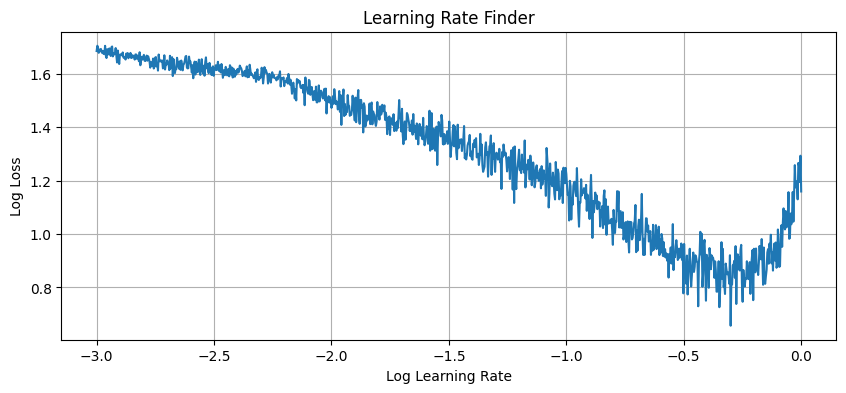

In [ ]:
# Define hyperparameters for fingding the proper learning rate
finder_steps = 1000  # Number of iterations to test learning rates
finder_batch_size = 80  # Batch size for each iteration

# Generate a range of learning rates on a logarithmic scale
lre = torch.linspace(-3, 0, finder_steps)  # Exponents from -3 to 0
lrs = 10 ** lre  # Convert exponents to actual learning rates
lri = []  # List to store learning rate exponents
lossi = []  # List to store corresponding losses

# Iterate over the range of learning rates
for i in range(finder_steps):
    # Randomly sample a batch of indices from the training set
    idx = torch.randint(0, Xtr.shape[0], (finder_batch_size,), generator=g)

    # Forward pass: embed the input batch
    emb = C[Xtr[idx]]  # Lookup character embeddings for the batch
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)  # Compute hidden layer activations with tanh nonlinearity
    logits = h @ W2 + b2  # Compute logits for the output layer
    loss = F.cross_entropy(logits, Ytr[idx])  # Calculate cross-entropy loss for the batch

    # Backward pass: reset gradients
    for p in parameters:
        p.grad = None  # Reset gradients from the previous iteration
    loss.backward()  # Compute gradients with respect to the loss

    # Update parameters using the current learning rate
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad  # Update parameters using gradient descent

    # Track the learning rate exponent and corresponding log loss
    lri.append(lre[i].item())
    lossi.append(loss.log10().item())

# Plot the learning rate finder results
plt.figure(figsize=(10, 4))
plt.plot(lri, lossi)
plt.title("Learning Rate Finder")
plt.xlabel("Log Learning Rate")
plt.ylabel("Log Loss")
plt.grid(True)
plt.show()   # Suggests optimal learning rate around 10^-0.3 ≈ 0.5

Model Training

In [ ]:
max_steps = 50000  # Maximum training steps
batch_size = 32     # Mini-batch size

# Lists to track training progress
stepi = []
lossi = []
losses = []

for step in range(max_steps):
    # Sample a random mini-batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,))

    # Forward pass
    emb = C[Xtr[idx]]  # Embedding layer
    h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)  # Hidden layer
    logits = h @ W2 + b2  # Output logits
    loss = F.cross_entropy(logits, Ytr[idx])  # Calculate cross-entropy loss

    # Print training loss every 2,000 steps
    if step % 2000 == 0:
        print(f"Step {step} | Training Loss: {loss.item():.4f}")

    # Backward pass
    for p in parameters:
        p.grad = None  # Reset gradients
    loss.backward()    # Compute gradients

    # Update parameters with SGD and scheduled learning rate decay
    lr = 0.5 if step < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # Track losses for visualization
    stepi.append(step)
    lossi.append(loss.log10().item())
    losses.append(loss.item())

Step 0 | Training Loss: 12.6007
Step 2000 | Training Loss: 6.6065
Step 4000 | Training Loss: 6.9078
Step 6000 | Training Loss: 7.5212
Step 8000 | Training Loss: 8.9378
Step 10000 | Training Loss: 8.5187
Step 12000 | Training Loss: 4.2392
Step 14000 | Training Loss: 4.7715
Step 16000 | Training Loss: 3.5730
Step 18000 | Training Loss: 3.3038
Step 20000 | Training Loss: 3.9721
Step 22000 | Training Loss: 4.0138
Step 24000 | Training Loss: 4.0470
Step 26000 | Training Loss: 4.2453
Step 28000 | Training Loss: 3.7571
Step 30000 | Training Loss: 3.8439
Step 32000 | Training Loss: 5.3978
Step 34000 | Training Loss: 3.8715
Step 36000 | Training Loss: 3.8322
Step 38000 | Training Loss: 4.1019
Step 40000 | Training Loss: 4.2307
Step 42000 | Training Loss: 4.4382
Step 44000 | Training Loss: 4.6252
Step 46000 | Training Loss: 4.0250
Step 48000 | Training Loss: 3.5807


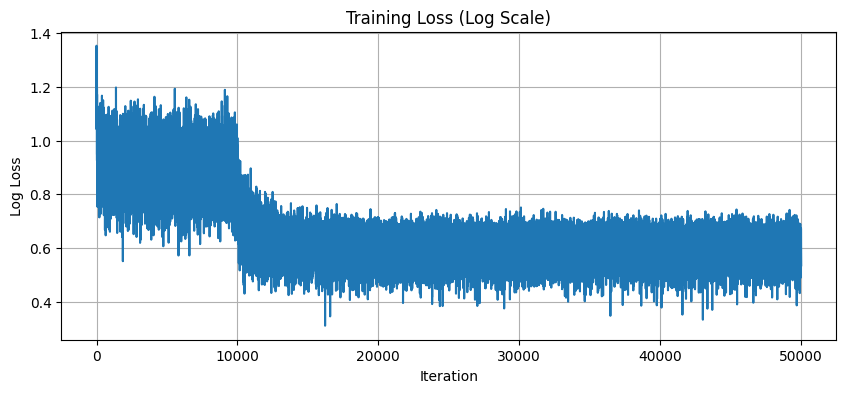

In [ ]:
# Plot training loss (log scale)
plt.figure(figsize=(10, 4))
plt.plot(stepi, lossi)
plt.title("Training Loss (Log Scale)")
plt.xlabel("Iteration")
plt.ylabel("Log Loss")
plt.grid(True)
plt.show()

Model Evaluation

In [ ]:
# Calculate training loss on full training set
emb = C[Xtr]  # Get embeddings for all training examples
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)  # Forward pass through hidden layer
logits = h @ W2 + b2  # Calculate output logits
train_loss = F.cross_entropy(logits, Ytr)  # Compute cross-entropy loss
print(f"Full training set loss: {train_loss.item():.4f}")

Full training set loss: 4.0080


In [ ]:

# Calculate validation loss on full validation set
emb = C[Xdev]  # Get embeddings for all validation examples
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)  # Forward pass through hidden layer
logits = h @ W2 + b2  # Calculate output logits
val_loss = F.cross_entropy(logits, Ydev)  # Compute cross-entropy loss
print(f"Validation set loss: {val_loss.item():.4f}")

Validation set loss: 4.2233


In [ ]:
# Calculate test loss on full test set
emb = C[Xte]  # Get embeddings for all test examples
h = torch.tanh(emb.view(-1, block_size * embedding_dim) @ W1 + b1)  # Forward pass through hidden layer
logits = h @ W2 + b2  # Calculate output logits
test_loss = F.cross_entropy(logits, Yte)  # Compute cross-entropy loss
print(f"Test set loss: {test_loss.item():.4f}")

Test set loss: 4.2060


Name Generation

In [ ]:
# Set a generator with a seed for reproducible name generation
g_generator = torch.Generator().manual_seed(2147483647 + 10)

# Define a function to generate a name using the trained model
def generate_name(g):
    context = [stoi['.']]*block_size  # Initialize context with end tokens
    generated = []
    while True:
        emb = C[torch.tensor([context])]  # Embed the current context
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)  # Compute hidden layer activations
        logits = h @ W2 + b2  # Compute output logits
        probs = F.softmax(logits, dim=1)  # Normalize logits to probabilities
        ix = torch.multinomial(probs, 1, generator=g).item()  # Sample the next token index
        context = context[1:] + [ix]  # Update context by sliding the window
        generated.append(ix)
        if ix == stoi['.']:  # Stop generating if end token is encountered
            break
    return ''.join(itos[i] for i in generated)

# Generate 19 names naturally using the model
generated_names = []
for _ in range(19):
    name = generate_name(g_generator)
    generated_names.append(name)

# Generate the 20th name starting with a compound surname
context = [stoi['.']]*block_size
compound_surname = random.choice(compound_surnames) # Randomly select a compound surname
cs_ix = stoi[compound_surname] # Get its index
context = context[1:] + [cs_ix] # Seed context with the compound surname
generated = [cs_ix] # Start generated sequence with compound surname
while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, 1, generator=g_generator).item()
    context = context[1:] + [ix]
    generated.append(ix)
    if ix == stoi['.']:
        break
generated_names.append(''.join(itos[i] for i in generated)) # Append the specially generated name to the list

# Print all generated names
print("Generated Names:")
for name in generated_names:
    print(name)


Generated Names:
吴丽波.
陶铁元.
张俊峰.
陈世华.
蔡三迪.
孙晨珊.
廖其华.
唐明蓉.
张池茹.
吕美.
杨照君.
张敬安.
李冰珍.
史洁丹.
周生楠.
崔素德.
彭晓坚.
林龙.
宋连英.
诸葛佩来.
